End-to-end pipeline for cleaning, fitting, and augmenting the NXP Conductors Aging dataset.

What it does:
1. Loads second sheet only.
2. Fixes 'Parameter name' values that start with 'nbti' -> 'pbti'.
3. Saves the cleaned DataFrame to 'TUe_data_modified.xlsx'.
4. Builds time points from the last 5 value columns (parses hours from headers).
5. Fits, per row, an exponential model constrained to pass through (0, 0):
       y(t) = A * (exp(B * t) - 1)
   (Two parameters: A before the exponent, B inside the exponent.)
6. Computes Sum of Squared Errors (SSE) and Pearson correlation (observed vs fitted).
7. Appends columns ['SSE_expfit', 'Corr_expfit'] and writes
   'TUe_data_with_fit_metrics.xlsx'.

In [1]:
from __future__ import annotations
import re
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# ---------- Configuration ----------

SECOND_SHEET_NAME_FALLBACK = 1  # index in case sheet name changes
INPUT_XLSX = "TUe_data (1).xlsx"
OUTPUT_XLSX_CLEAN = "TUe_data_modified.xlsx"
OUTPUT_XLSX_WITH_METRICS = "TUe_data_with_fit_metrics.xlsx"

In [3]:
# ---------- Checking Exponential Fit ----------

def zeroExp(x, c1, c2):
    """
    Exponential curve guarenteed to go through (0,0).
    """
    return c1 * (np.exp(c2 * x) - 1)

def findRSquaresExp(xs, ys, toggle=False):
    """
    For a set of points, fit exponential model and return a correlation R^2 value to the fitting.
    """
    # scale the xs and ys
    xs = xs * 1/np.average(xs)
    ys = ys * 1/np.average(ys)
    
    # perform the fit
    try:
        params, cv = curve_fit(zeroExp, xs, ys, p0=[1,1],maxfev=60000)
    except RuntimeError:
        print("Uh ohhh")
        params = [1, 0]
    c1, c2 = params
    sampleRate = 20_000 # Hz
    tauSec = (1 / 1) / sampleRate

    # determine quality of the fit
    squaredDiffs = np.square(ys - zeroExp(xs, c1, c2))
    squaredDiffsFromMean = np.square(ys - np.mean(ys))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)

    # plot the results
    if (toggle):
        plt.plot(xs, ys, '.', label="data")
        plt.plot(np.arange(0, xs[-1]+0.02, 0.01), zeroExp(np.arange(0, xs[-1]+0.02, 0.01), c1, c2), '--', label="fitted")
        plt.xlabel('Time Scaled', fontsize=12)
        plt.ylabel('Frequency Scaled', fontsize=12)
        plt.title("Fitted Exponential Curve")
        print(f"Y = {c1} * (e^({c2} * x) - 1)")

    # filter functions attempting to overfit to be linear
    if (not toggle and c2 < 0.1):
        rSquared = -1
    
    return rSquared

Y = 2.4027416315978846e-09 * (e^(11.698996958239945 * x) - 1)
RSquared: 0.9853017110865901


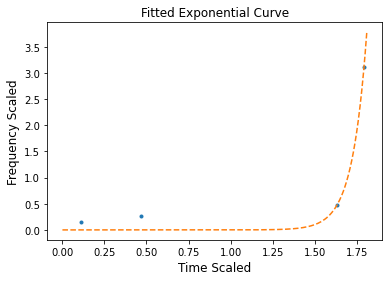

In [4]:
# --------- Example of Exponetial Fitting ----------

# Attempt
x_data = np.array([720, 3120, 10920, 12000])
y_data = np.array([17.60094081, 30.69048138, 56.00624025, 370.2194357])


# Logorithmic
#x_data = np.array([0, 720.,  3120., 10920., 12000.])
#y_data = np.array([1, 10, 12, 12])

# Linear
#x_data = np.array([1,2,3,4])
#y_data = np.array([1,2.2,2.8,4])

# Exponential
#x_data = np.array([1,2,3,4])
#y_data = np.array([1,3,7,15])


print("RSquared: " + str(findRSquaresExp(x_data, y_data, True)))

In [5]:
# ---------- Utilities ----------

def load_second_sheet(path: str, sheet_index_or_name=SECOND_SHEET_NAME_FALLBACK) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    sheet = sheet_index_or_name
    if isinstance(sheet_index_or_name, int):
        sheet = xls.sheet_names[sheet_index_or_name]
    df = pd.read_excel(path, sheet_name=sheet)
    return df


def fix_parameter_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    In 'Parameter name', replace values starting with 'nbti' -> corresponding 'pbti'.
    E.g., nbtidamage -> pbtidamage, nbtideltavth -> pbtideltavth, nbtivthdegr -> pbtivthdegr
    """
    if "Parameter name" not in df.columns:
        raise KeyError("Column 'Parameter name' not found.")

    def _fix(name: str) -> str:
        if isinstance(name, str) and name.startswith("nbti"):
            return re.sub(r"^nbti", "pbti", name)
        return name

    df = df.copy()
    df["Parameter name"] = df["Parameter name"].map(_fix)
    return df


def save_excel(df: pd.DataFrame, path: str) -> None:
    df.to_excel(path, index=False)


def parse_time_from_header(col_name: str) -> float:
    """
    Extract hours from headers like 'Value at t=3120h', 'Value at t=0', 'Value at t=12000h'
    Returns float hours. Raises ValueError if no time pattern found.
    """
    # Common patterns
    patterns = [
        r"t\s*=\s*(\d+)\s*h",  # Value at t=3120h
        r"t\s*=\s*(\d+)\b",    # Value at t=0
    ]
    for pat in patterns:
        m = re.search(pat, str(col_name), flags=re.IGNORECASE)
        if m:
            return float(m.group(1))
    raise ValueError(f"Could not parse time from column header: '{col_name}'")


def get_time_and_value_columns(df: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
    """
    Identify the last 5 columns as the time-series value columns.
    Parse their time stamps (in hours) from header text.
    Returns:
        t_hours: np.ndarray shape (5,)
        value_cols: list of 5 column names
    """
    if df.shape[1] < times_count:
        raise ValueError("DataFrame does not have at least 5 columns to extract time series.")

    value_cols = list(df.columns[-times_count:])
    print(value_cols)
    t_hours = np.array([parse_time_from_header(c) for c in value_cols], dtype=float)
    return t_hours, value_cols

In [6]:
# ---------- Model & Fitting ----------

def fit_all_rows_and_augment(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row, fit exponential model and append columns:
        - 'findRSquaresExp'
    """
    t_hours, value_cols = get_time_and_value_columns(df)
    print(t_hours)

    R2_list: List[float] = []
    b = True

    for _, row in df[value_cols].iterrows():
        y = row.values.astype(float)
        if b:
            print(y)
            b = False

        RSquared = findRSquaresExp(t_hours, y)

        R2_list.append(RSquared)

    out = df.copy()
    out["r2_expfit"] = R2_list
    return out

In [7]:
# ---------- Public API ----------

def run_pipeline(
    input_xlsx: str = INPUT_XLSX,
    output_clean_xlsx: str = OUTPUT_XLSX_CLEAN,
    output_with_metrics_xlsx: str = OUTPUT_XLSX_WITH_METRICS,
    sheet_index_or_name=SECOND_SHEET_NAME_FALLBACK,
) -> Dict[str, str]:
    """
    Orchestrates the whole workflow and returns paths to outputs.
    """
    # 1) Load second sheet
    df = load_second_sheet(input_xlsx, sheet_index_or_name=sheet_index_or_name)

    # 2) Fix 'Parameter name' nbti* -> pbti*
    df_clean = fix_parameter_names(df)

    # 3) Save cleaned DataFrame (to be used for the rest)
    save_excel(df_clean, output_clean_xlsx)

    # 4) Fit per row and compute metrics on the CLEANED dataframe
    df_with_metrics = fit_all_rows_and_augment(df_clean)

    # 5) Save augmented dataframe
    save_excel(df_with_metrics, output_with_metrics_xlsx)

    return {
        "cleaned": output_clean_xlsx,
        "with_metrics": output_with_metrics_xlsx,
    }


In [8]:
print("=== TU/e Aging Dataset Pipeline ===")
print(f"Input Excel: {INPUT_XLSX}")
print("Processing second sheet only...")
times_count = 5
paths = run_pipeline(
    input_xlsx=INPUT_XLSX,
    output_clean_xlsx=OUTPUT_XLSX_CLEAN,
    output_with_metrics_xlsx=OUTPUT_XLSX_WITH_METRICS,
    sheet_index_or_name=(2*1-1),  # use index 1 -> second sheet
)
print("Done.")
print(f"- Cleaned file (nbti->pbti fixed): {paths['cleaned']}")
print(f"- With fit metrics (SSE, Corr):   {paths['with_metrics']}")

=== TU/e Aging Dataset Pipeline ===
Input Excel: TUe_data (1).xlsx
Processing second sheet only...
['Value at t=0', 'Value at t=720h', 'Value at t=3120h', 'Value at t=10920h', 'Value at t=12000h']
[    0.   720.  3120. 10920. 12000.]
[0.00000000e+00 1.14247330e-27 2.75978523e-26 3.18678925e-26
 3.18693201e-26]
Done.
- Cleaned file (nbti->pbti fixed): TUe_data_modified.xlsx
- With fit metrics (SSE, Corr):   TUe_data_with_fit_metrics.xlsx
